https://twitter.com/drk0311/status/1537076913788751872

https://www.resuscitationjournal.com/article/S0300-9572(20)30105-2/fulltext

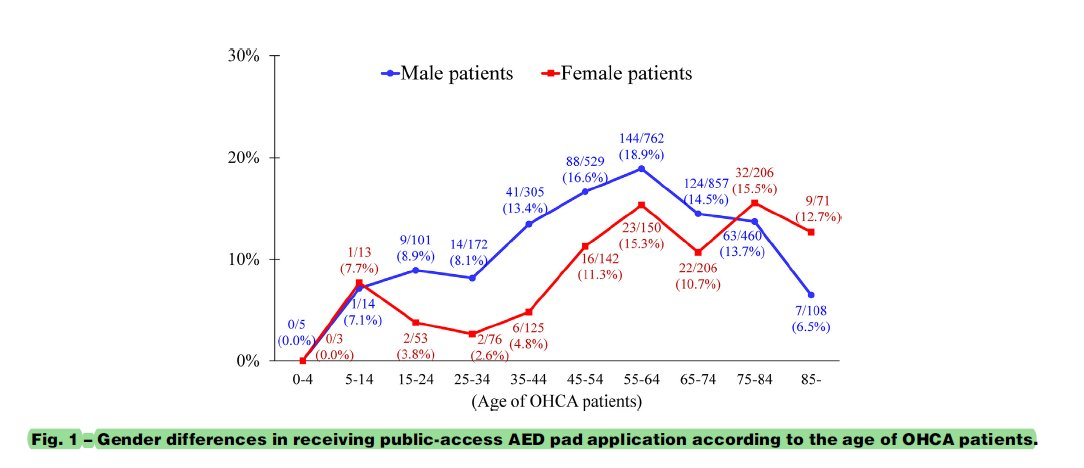

In [1]:
ENV["LINES"], ENV["COLUMNS"] = 100, 300
using Distributions
using StatsPlots
default(fmt=:png, size=(400, 250), titlefontsize=10)
using KernelDensity
using DataFrames
using Roots
using StatsFuns

safemul(x, y) = x == 0 ? x : isinf(x) ? typeof(x)(Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

safediv (generic function with 1 method)

In [2]:
function pvalue_wilson(n, k, p)
    p̂ = k/n
    SE = √(p*(1-p)/n)
    2ccdf(Normal(), abs(p̂ - p)/SE)
end

function confint_wilson(n, k; α = 0.05)
    p̂ = k/n
    z = quantile(Normal(), 1-α/2)
    a, b, c = 1+z^2/n, p̂+z^2/(2n), p̂^2
    # ap² - 2bp + c = 0 を解く.
    sqrtD = √(b^2 - a*c)
    p_L = (b - sqrtD)/a
    p_U = (b + sqrtD)/a
    [p_L, p_U]
end

confint_wilson (generic function with 1 method)

In [3]:
oddsratiohat(a, b, c, d) = safediv(a*d, b*c)
stderr_logoddsratiohat(a, b, c, d) = √(1/a + 1/b + 1/c + 1/d)

function pvalue_or_wald(a, b, c, d; ω=1)
    logORhat = log(oddsratiohat(a, b, c, d))
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logORhat - log(ω)), SEhat_logORhat))
end

function confint_or_wald(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    ORhat = oddsratiohat(a, b, c, d)
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logORhat), ORhat), safemul(exp(z*SEhat_logORhat), ORhat)]
end

confint_or_wald (generic function with 1 method)

In [4]:
riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)
stderr_logriskratiohat(a, b, c, d) = √(1/a - 1/(a+b) + 1/c - 1/(c+d))

function pvalue_rr_wald(a, b, c, d; ρ=1)
    logRRhat = log(riskratiohat(a, b, c, d))
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logRRhat - log(ρ)), SEhat_logRRhat))
end

function confint_rr_wald(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    RRhat = riskratiohat(a, b, c, d)
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logRRhat), RRhat), safemul(exp(z*SEhat_logRRhat), RRhat)]
end

confint_rr_wald (generic function with 1 method)

In [5]:
function delta(a, b, c, d; ω=1)
    A, B, C = 1-ω, a+d+ω*(b+c), a*d-ω*b*c
    isinf(ω) ? typeof(ω)(-min(b, c)) : safediv(2C, B + √(B^2 - 4A*C))
end

# correction = 0.5 は連続性補正を与える.
function _chisqstat_or(a, b, c, d, δ; correction=0.0)
    ã, b̃, c̃, d̃ = a-δ, b+δ, c+δ, d-δ
    safemul(max(0, abs(δ)-correction)^2, 1/ã + 1/b̃ + 1/c̃ + 1/d̃)
end

function chisqstat_or(a, b, c, d; ω=1, correction=0.0)
    δ = delta(a, b, c, d; ω)
    _chisqstat_or(a, b, c, d, δ; correction)
end

function pvalue_or_pearson(a, b, c, d; ω=1, correction=0.0)
    χ² = chisqstat_or(a, b, c, d; ω, correction)
    ccdf(Chisq(1), χ²)
end

function confint_or_pearson(a, b, c, d; α=0.05, correction=0.0)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0.0, Inf]
    f(ω) = logit(pvalue_or_pearson(a, b, c, d; ω, correction)) - logit(α)
    if a == 0 || d == 0
        [0.0, find_zero(f, 1.0)]
    elseif b == 0 || c == 0
        [find_zero(f, 1.0), Inf]
    else
        ω_L, ω_U = confint_or_wald(a, b, c, d; α)
        [find_zero(f, ω_L), find_zero(f, ω_U)]
    end
end

confint_or_pearson (generic function with 1 method)

In [6]:
function Delta(a, b, c, d; ρ=1)
    m, n = a+b, c+d
    A, B, C = ρ-1, n-a+ρ*(m-c), a*n-ρ*m*c
    isinf(ρ) ? typeof(ω)(-c) : safediv(2C, B + √(B^2 - 4A*C))
end

function _chisqstat_rr(a, b, c, d, Δ)
    m, n = a+b, c+d
    safemul(Δ^2, safediv(b, m*(a-Δ)) + safediv(d, n*(c+Δ)))
end

function chisqstat_rr(a, b, c, d; ρ=1)
    Δ = Delta(a, b, c, d; ρ)
    _chisqstat_rr(a, b, c, d, Δ)
end

function pvalue_rr_pearson(a, b, c, d; ρ=1)
    χ² = chisqstat_rr(a, b, c, d; ρ)
    ccdf(Chisq(1), χ²)
end

function confint_rr_pearson(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0.0, Inf]
    f(ρ) = logit(pvalue_rr_pearson(a, b, c, d; ρ)) - logit(α)
    if a == 0 || d == 0
        [0.0, find_zero(f, 1.0)]
    elseif b == 0 || c == 0
        [find_zero(f, 1.0), Inf]
    else
        ρ_L, ρ_U = confint_rr_wald(a, b, c, d; α)
        [find_zero(f, ρ_L), find_zero(f, ρ_U)]
    end
end

confint_rr_pearson (generic function with 1 method)

In [7]:
aed = [
      0   5   0   3
      1  14   1  13
      9 101   2  53
     14 172   2  76
     41 305   6 125
     88 529  16 142
    144 762  23 150
    124 857  22 206
     63 460  32 206
      7 108   9  71
]

age = [
     0  4
     5 14
    15 24
    25 34
    35 44
    45 54
    55 64
    65 74
    75 84
    85 120
]

name = [
    "min of age"
    "max of age"
    "Male AED"
    "Male data size"
    "Female AED"
    "Female data size"
]

df = DataFrame([age aed], name)

,min of age,max of age,Male AED,Male data size,Female AED,Female data size
,Int64,Int64,Int64,Int64,Int64,Int64
1,0,4,0,5,0,3
2,5,14,1,14,1,13
3,15,24,9,101,2,53
4,25,34,14,172,2,76
5,35,44,41,305,6,125
6,45,54,88,529,16,142
7,55,64,144,762,23,150
8,65,74,124,857,22,206
9,75,84,63,460,32,206


In [8]:
Male_CI = vcat((confint_wilson(n, k)' for (n, k) in zip(df."Male data size", df."Male AED"))...)
Female_CI = vcat((confint_wilson(n, k)' for (n, k) in zip(df."Female data size", df."Female AED"))...)
df."Male CI L" = Male_CI[:,1]
df."Male CI U" = Male_CI[:,2]
df."Female CI L" = Female_CI[:,1]
df."Female CI U" = Female_CI[:,2]
df

,min of age,max of age,Male AED,Male data size,Female AED,Female data size,Male CI L,Male CI U,Female CI L,Female CI U
,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,0,4,0,5,0,3,0.0,0.434482,0.0,0.561497
2,5,14,1,14,1,13,0.0127222,0.314687,0.0137104,0.33314
3,15,24,9,101,2,53,0.0475892,0.160739,0.0104103,0.127543
4,25,34,14,172,2,76,0.0491027,0.131978,0.00724666,0.0909662
5,35,44,41,305,6,125,0.10066,0.177287,0.022182,0.100771
6,45,54,88,529,16,142,0.137046,0.200468,0.0705565,0.1752
7,55,64,144,762,23,150,0.162766,0.218307,0.1044,0.21958
8,65,74,124,857,22,206,0.122723,0.16983,0.0715905,0.156398
9,75,84,63,460,32,206,0.108532,0.171395,0.112235,0.211064


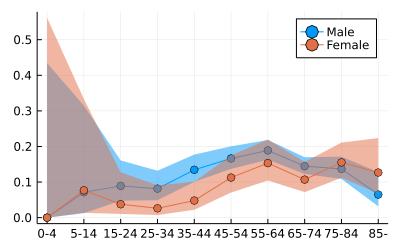

In [9]:
xticklabel = ["""$a-$(b > 100 ? "" : b)""" for (a,b) in zip(df."min of age", df."max of age")]
xtick = (1:10, xticklabel)
a = df."Male AED"
m = df."Male data size"
M = @. a/m
MCI_L = df."Male CI L"
MCI_U = df."Male CI U"
c = df."Female AED"
n = df."Female data size"
F = @. c/n
FCI_L = df."Female CI L"
FCI_U = df."Female CI U"

plot()
plot!(M; label="Male", marker=:o, ribbon=(M - MCI_L, MCI_U - M))
plot!(F; label="Female", marker=:o, ribbon=(F - FCI_L, FCI_U - F))
plot!(; xtick)

In [10]:
ORhat = @. oddsratiohat(a, m-a, c, n-c)

10-element Vector{Real}:
 0
 0.9230769230769231
 2.494565217391304
 3.278481012658228
 3.0801767676767677
 1.5714285714285714
 1.2866188265090757
 1.414857993302741
 0.8628778337531486
 0.47744774477447743

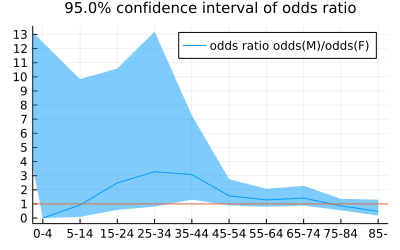

In [11]:
α = 0.05
ORCI = vcat((confint_or_pearson(a, m-a, c, n-c; α)' for (m, a, n, c)
        in zip(df."Male data size", df."Male AED", df."Female data size", df."Female AED"))...)
ORCI_L = ORCI[:,1]
ORCI_U = ORCI[:,2]

plot(ORhat; label="odds ratio odds(M)/odds(F)", ribbon=(ORhat-ORCI_L, ORCI_U-ORhat))
hline!([1]; label="")
plot!(; xtick, ytick=0:20)
title!("$(100(1-α))% confidence interval of odds ratio")

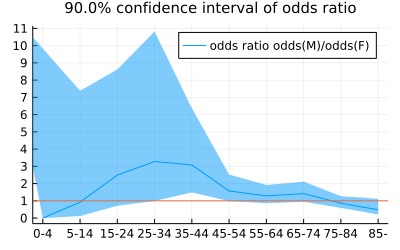

In [12]:
α = 0.1
ORCI = vcat((confint_or_pearson(a, m-a, c, n-c; α)' for (m, a, n, c)
        in zip(df."Male data size", df."Male AED", df."Female data size", df."Female AED"))...)
ORCI_L = ORCI[:,1]
ORCI_U = ORCI[:,2]

plot(ORhat; label="odds ratio odds(M)/odds(F)", ribbon=(ORhat-ORCI_L, ORCI_U-ORhat))
hline!([1]; label="")
plot!(; xtick, ytick=0:20)
title!("$(100(1-α))% confidence interval of odds ratio")

In [13]:
RRhat = @. riskratiohat(a, m-a, c, n-c)

10-element Vector{Real}:
 0
 0.9285714285714286
 2.3613861386138613
 3.0930232558139537
 2.800546448087432
 1.4763705103969755
 1.2324546388223212
 1.3548318659170469
 0.8816576086956521
 0.5113168724279835

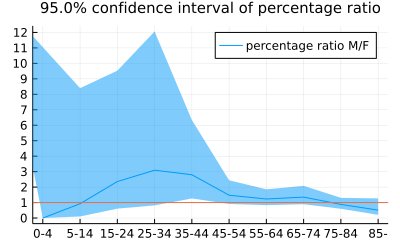

In [14]:
α = 0.05
RRCI = vcat((confint_rr_pearson(a, m-a, c, n-c; α)' for (m, a, n, c)
        in zip(df."Male data size", df."Male AED", df."Female data size", df."Female AED"))...)
RRCI_L = RRCI[:,1]
RRCI_U = RRCI[:,2]

plot(RRhat; label="percentage ratio M/F", ribbon=(RRhat-RRCI_L, RRCI_U-RRhat))
hline!([1]; label="")
plot!(; xtick, ytick=0:20)
title!("$(100(1-α))% confidence interval of percentage ratio")

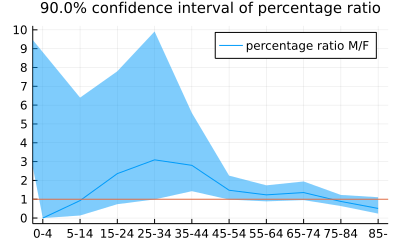

In [15]:
α = 0.1
RRCI = vcat((confint_rr_pearson(a, m-a, c, n-c; α)' for (m, a, n, c)
        in zip(df."Male data size", df."Male AED", df."Female data size", df."Female AED"))...)
RRCI_L = RRCI[:,1]
RRCI_U = RRCI[:,2]

plot(RRhat; label="percentage ratio M/F", ribbon=(RRhat-RRCI_L, RRCI_U-RRhat))
hline!([1]; label="")
plot!(; xtick, ytick=0:20)
title!("$(100(1-α))% confidence interval of percentage ratio")

In [16]:
function plot_pvalues(; idx = 3:8, xlim = (1/15, 15), df=df)
    @show agemin = df."min of age"[idx[begin]]
    @show agemax = df."max of age"[idx[end]]
    @show a = sum(df."Male AED"[idx])
    @show m = sum(df."Male data size"[idx])
    @show c = sum(df."Female AED"[idx])
    @show n = sum(df."Female data size"[idx])
    println()

    @show ORhat = oddsratiohat(a, m-a, c, n-c)
    @show RRhat = riskratiohat(a, m-a, c, n-c)
    @show pvalue_or_pearson(a, m-a, c, n-c)
    @show pvalue_rr_pearson(a, m-a, c, n-c)
    @show confint_or_pearson(a, m-a, c, n-c)
    @show confint_rr_pearson(a, m-a, c, n-c)

    xtick_ = vcat((10.0^k*[1, 2, 5] for k in -1:2)...)
    xtick_ = xtick_[@.(xlim[begin] ≤ xtick_ ≤ xlim[end])]
    @show xtick_
    xtick = (xtick_, string.(xtick_))
    
    P = plot(ω -> pvalue_or_pearson(a, m-a, c, n-c; ω), xlim...; label="")
    vline!([ORhat]; label="$(round(ORhat; digits=2))", ls=:dash, c=1)
    vline!([1]; label="", c=2)
    plot!(; xscale=:log10, xtick, ytick=0:0.1:1)
    plot!(; xguide="hypothetical odds ratio M/F", yguide="P-value")
    plot!(; bottommargin=4Plots.mm, leftmargin=4Plots.mm)
    
    Q = plot(ρ -> pvalue_rr_pearson(a, m-a, c, n-c; ρ), xlim...; label="")
    vline!([RRhat]; label="$(round(RRhat; digits=2))", ls=:dash, c=1)
    vline!([1]; label="", c=2)
    plot!(; xscale=:log10, xtick, ytick=0:0.1:1)
    plot!(; xguide="hypothetical percentage ratio M/F", yguide="P-value")
    plot!(; bottommargin=4Plots.mm, leftmargin=4Plots.mm)
    
    Title = plot(; framestyle=:none, bottommargin=-50Plots.px)
    title!("""Age: $agemin - $(agemax > 100 ? "infinity" : agemax),   Data: Male $a/$m,  Female $c/$n""")

    plot(Title, P, Q; size=(800, 250), layout=@layout[a{0.1h}; [b c]])
    plot!(; titlefontsize=9, tickfontsize=6, guidefontsize=8)
end

plot_pvalues (generic function with 1 method)

agemin = df.:("min of age")[idx[begin]] = 0
agemax = df.:("max of age")[idx[end]] = 120
a = sum(df.:("Male AED")[idx]) = 491
m = sum(df.:("Male data size")[idx]) = 3313
c = sum(df.:("Female AED")[idx]) = 113
n = sum(df.:("Female data size")[idx]) = 1045

ORhat = oddsratiohat(a, m - a, c, n - c) = 1.4350332093600848
RRhat = riskratiohat(a, m - a, c, n - c) = 1.3705595281660607
pvalue_or_pearson(a, m - a, c, n - c) = 0.0010806593259981752
pvalue_rr_pearson(a, m - a, c, n - c) = 0.0010806593259981778
confint_or_pearson(a, m - a, c, n - c) = [1.1549234246206317, 1.7830498354889075]
confint_rr_pearson(a, m - a, c, n - c) = [1.1327701387692632, 1.6628863305800288]
xtick_ = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]


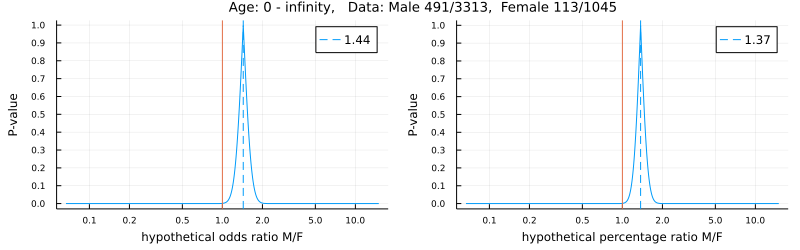

In [17]:
P_all = plot_pvalues(idx = 1:10)

agemin = df.:("min of age")[idx[begin]] = 15
agemax = df.:("max of age")[idx[end]] = 74
a = sum(df.:("Male AED")[idx]) = 420
m = sum(df.:("Male data size")[idx]) = 2726
c = sum(df.:("Female AED")[idx]) = 71
n = sum(df.:("Female data size")[idx]) = 752

ORhat = oddsratiohat(a, m - a, c, n - c) = 1.7469430634108205
RRhat = riskratiohat(a, m - a, c, n - c) = 1.6318601262748906
pvalue_or_pearson(a, m - a, c, n - c) = 3.189636510252236e-5
pvalue_rr_pearson(a, m - a, c, n - c) = 3.189636510252227e-5
confint_or_pearson(a, m - a, c, n - c) = [1.340290161506473, 2.2769033775782224]
confint_rr_pearson(a, m - a, c, n - c) = [1.2896108034148535, 2.073584845941051]
xtick_ = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]


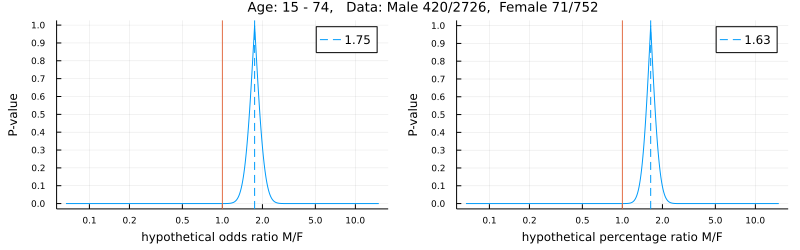

In [18]:
P15_74 = plot_pvalues(idx = 3:8)

agemin = df.:("min of age")[idx[begin]] = 0
agemax = df.:("max of age")[idx[end]] = 14
a = sum(df.:("Male AED")[idx]) = 1
m = sum(df.:("Male data size")[idx]) = 19
c = sum(df.:("Female AED")[idx]) = 1
n = sum(df.:("Female data size")[idx]) = 16

ORhat = oddsratiohat(a, m - a, c, n - c) = 0.8333333333333334
RRhat = riskratiohat(a, m - a, c, n - c) = 0.8421052631578947
pvalue_or_pearson(a, m - a, c, n - c) = 0.9002870922417828
pvalue_rr_pearson(a, m - a, c, n - c) = 0.9002870922417828
confint_or_pearson(a, m - a, c, n - c) = [0.0801435715580236, 8.66002188153458]
confint_rr_pearson(a, m - a, c, n - c) = [0.09234058530532781, 7.726827061487374]
xtick_ = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]


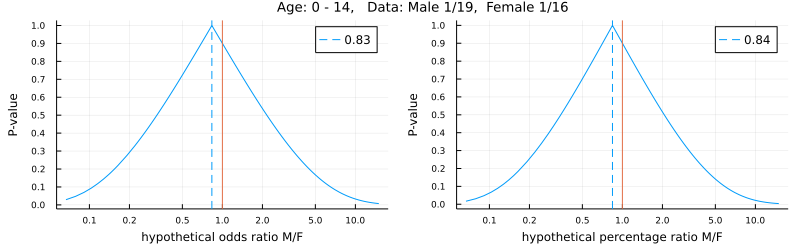

In [19]:
P1 = plot_pvalues(idx = 1:2)

agemin = df.:("min of age")[idx[begin]] = 15
agemax = df.:("max of age")[idx[end]] = 34
a = sum(df.:("Male AED")[idx]) = 23
m = sum(df.:("Male data size")[idx]) = 273
c = sum(df.:("Female AED")[idx]) = 4
n = sum(df.:("Female data size")[idx]) = 129

ORhat = oddsratiohat(a, m - a, c, n - c) = 2.875
RRhat = riskratiohat(a, m - a, c, n - c) = 2.717032967032967
pvalue_or_pearson(a, m - a, c, n - c) = 0.04649633976321601
pvalue_rr_pearson(a, m - a, c, n - c) = 0.04649633976321601
confint_or_pearson(a, m - a, c, n - c) = [1.0153284606252082, 8.114114209489836]
confint_rr_pearson(a, m - a, c, n - c) = [1.0142211046080967, 7.429206043822878]
xtick_ = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]


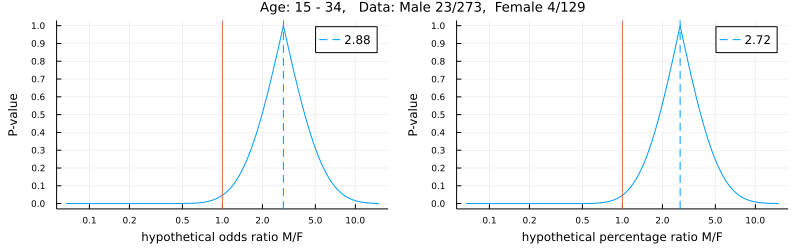

In [20]:
P2 = plot_pvalues(idx = 3:4)

agemin = df.:("min of age")[idx[begin]] = 35
agemax = df.:("max of age")[idx[end]] = 54
a = sum(df.:("Male AED")[idx]) = 129
m = sum(df.:("Male data size")[idx]) = 834
c = sum(df.:("Female AED")[idx]) = 22
n = sum(df.:("Female data size")[idx]) = 267

ORhat = oddsratiohat(a, m - a, c, n - c) = 2.0377176015473886
RRhat = riskratiohat(a, m - a, c, n - c) = 1.8772073250490517
pvalue_or_pearson(a, m - a, c, n - c) = 0.0028071401889560974
pvalue_rr_pearson(a, m - a, c, n - c) = 0.002807140188956103
confint_or_pearson(a, m - a, c, n - c) = [1.2719591136914077, 3.2635047083428863]
confint_rr_pearson(a, m - a, c, n - c) = [1.2324254462001956, 2.892265842440532]
xtick_ = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]


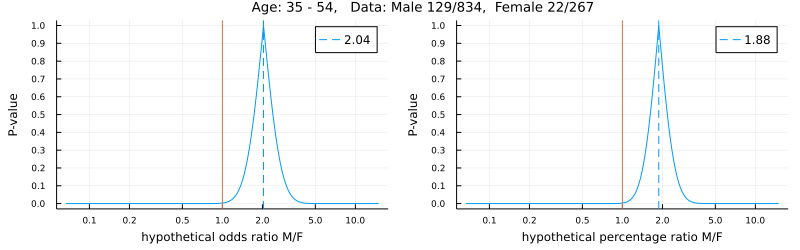

In [21]:
P3 = plot_pvalues(idx = 5:6)

agemin = df.:("min of age")[idx[begin]] = 55
agemax = df.:("max of age")[idx[end]] = 74
a = sum(df.:("Male AED")[idx]) = 268
m = sum(df.:("Male data size")[idx]) = 1619
c = sum(df.:("Female AED")[idx]) = 45
n = sum(df.:("Female data size")[idx]) = 356

ORhat = oddsratiohat(a, m - a, c, n - c) = 1.3709680072374373
RRhat = riskratiohat(a, m - a, c, n - c) = 1.3095600851005422
pvalue_or_pearson(a, m - a, c, n - c) = 0.06718651974331834
pvalue_rr_pearson(a, m - a, c, n - c) = 0.06718651974331834
confint_or_pearson(a, m - a, c, n - c) = [0.9780730250109688, 1.9215046274692602]
confint_rr_pearson(a, m - a, c, n - c) = [0.9815515401394073, 1.7626638929598641]
xtick_ = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]


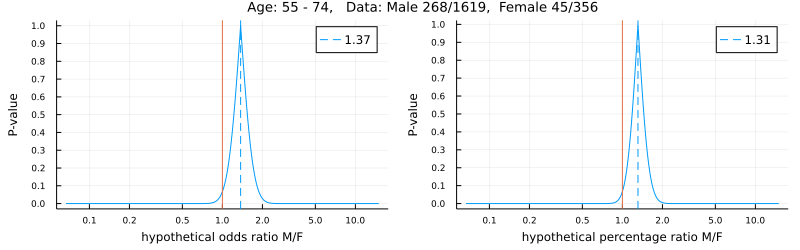

In [22]:
P4 = plot_pvalues(idx = 7:8)

agemin = df.:("min of age")[idx[begin]] = 75
agemax = df.:("max of age")[idx[end]] = 120
a = sum(df.:("Male AED")[idx]) = 70
m = sum(df.:("Male data size")[idx]) = 568
c = sum(df.:("Female AED")[idx]) = 41
n = sum(df.:("Female data size")[idx]) = 277

ORhat = oddsratiohat(a, m - a, c, n - c) = 0.8090900186110295
RRhat = riskratiohat(a, m - a, c, n - c) = 0.8326176571624871
pvalue_or_pearson(a, m - a, c, n - c) = 0.3169242663724792
pvalue_rr_pearson(a, m - a, c, n - c) = 0.3169242663724792
confint_or_pearson(a, m - a, c, n - c) = [0.535073034015082, 1.2232430930550307]
confint_rr_pearson(a, m - a, c, n - c) = [0.5850447964091303, 1.1919401251705601]
xtick_ = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]


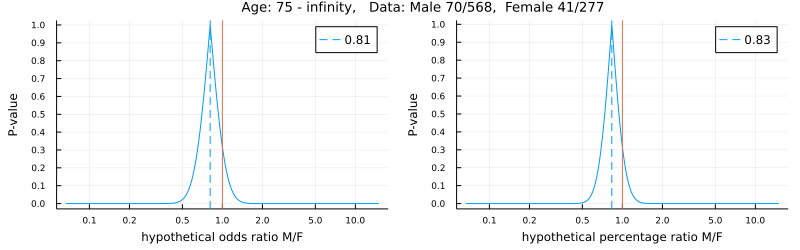

In [23]:
P5 = plot_pvalues(idx = 9:10)

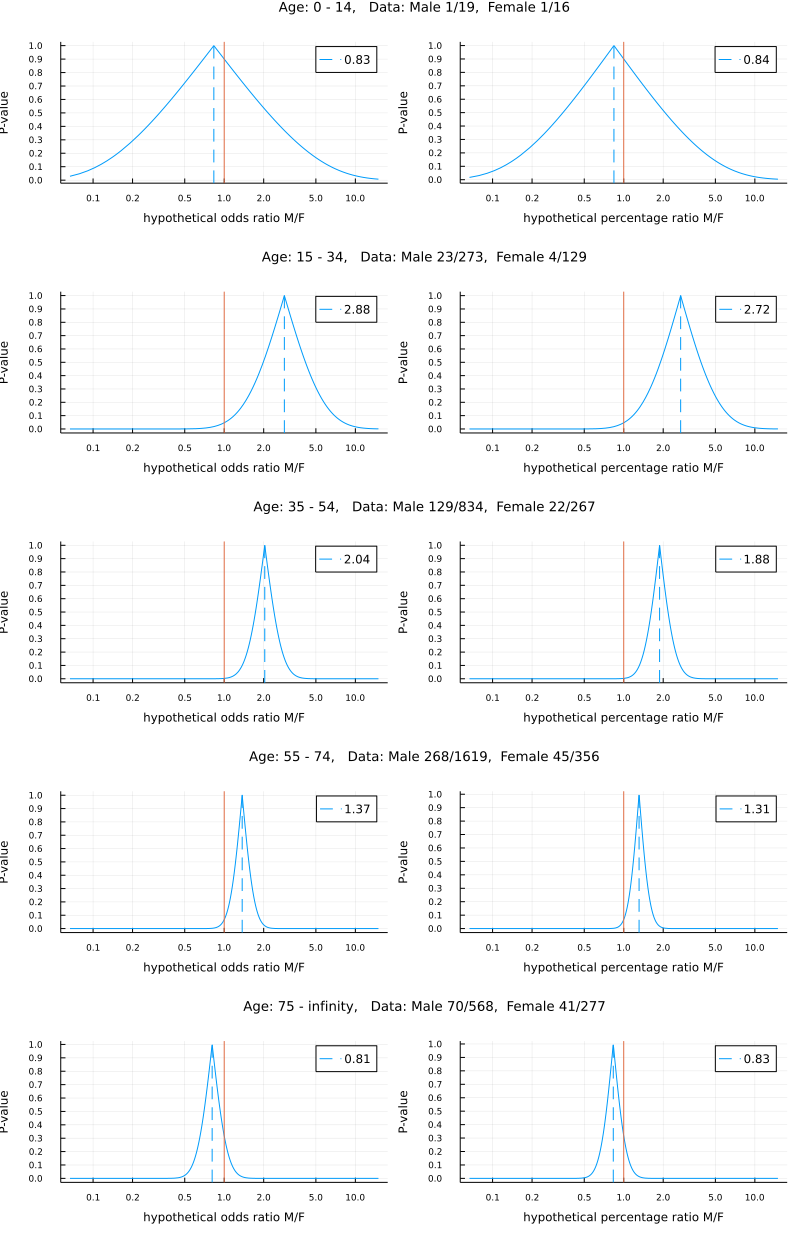

In [24]:
plot(P1, P2, P3, P4, P5; size=(800, 1250), layout=(5, 1))

In [25]:
aed2 = aed[begin:2:end, :] + aed[begin+1:2:end, :]
age2 = vcat(([age[i,1] age[i+1,2]] for i in 1:2:10)...)
df2 = DataFrame([age2 aed2], name)

Male2_CI = vcat((confint_wilson(n, k)' for (n, k) in zip(df2."Male data size", df2."Male AED"))...)
Female2_CI = vcat((confint_wilson(n, k)' for (n, k) in zip(df2."Female data size", df2."Female AED"))...)
df2."Male CI L" = Male2_CI[:,1]
df2."Male CI U" = Male2_CI[:,2]
df2."Female CI L" = Female2_CI[:,1]
df2."Female CI U" = Female2_CI[:,2]
df2

,min of age,max of age,Male AED,Male data size,Female AED,Female data size,Male CI L,Male CI U,Female CI L,Female CI U
,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,0,14,1,19,1,16,0.00935199,0.246387,0.0111193,0.283287
2,15,34,23,273,4,129,0.0567941,0.123242,0.012123,0.0770167
3,35,54,129,834,22,267,0.131724,0.180795,0.0550415,0.121599
4,55,74,268,1619,45,356,0.148226,0.184426,0.0958276,0.164958
5,75,120,70,568,41,277,0.09871,0.152831,0.111019,0.194639


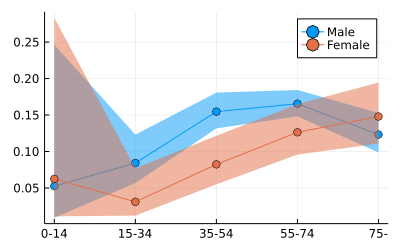

In [26]:
xticklabel2 = ["""$a-$(b > 100 ? "" : b)""" for (a,b) in zip(df2."min of age", df2."max of age")]
xtick2 = (1:5, xticklabel2)
a2 = df2."Male AED"
m2 = df2."Male data size"
M2 = @. a2/m2
MCI2_L = df2."Male CI L"
MCI2_U = df2."Male CI U"
c2 = df2."Female AED"
n2 = df2."Female data size"
F2 = @. c2/n2
FCI2_L = df2."Female CI L"
FCI2_U = df2."Female CI U"

plot()
plot!(M2; label="Male", marker=:o, ribbon=(M2 - MCI2_L, MCI2_U - M2))
plot!(F2; label="Female", marker=:o, ribbon=(F2 - FCI2_L, FCI2_U - F2))
plot!(; xtick=xtick2)

In [27]:
ORhat2 = @. oddsratiohat(a2, m2-a2, c2, n2-c2)

5-element Vector{Float64}:
 0.8333333333333334
 2.875
 2.0377176015473886
 1.3709680072374373
 0.8090900186110295

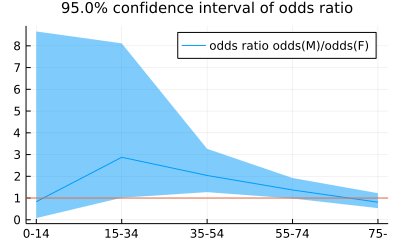

In [28]:
α = 0.05
ORCI2 = vcat((confint_or_pearson(a2, m2-a2, c2, n2-c2; α)' for (m2, a2, n2, c2)
        in zip(df2."Male data size", df2."Male AED", df2."Female data size", df2."Female AED"))...)
ORCI2_L = ORCI2[:,1]
ORCI2_U = ORCI2[:,2]

plot(ORhat2; label="odds ratio odds(M)/odds(F)", ribbon=(ORhat2-ORCI2_L, ORCI2_U-ORhat2))
hline!([1]; label="")
plot!(; xtick=xtick2, ytick=0:20)
title!("$(100(1-α))% confidence interval of odds ratio")

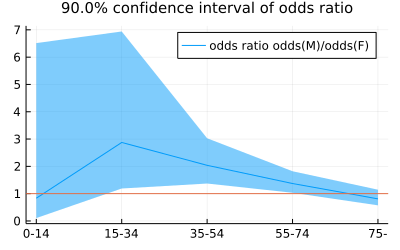

In [29]:
α = 0.10
ORCI2 = vcat((confint_or_pearson(a2, m2-a2, c2, n2-c2; α)' for (m2, a2, n2, c2)
        in zip(df2."Male data size", df2."Male AED", df2."Female data size", df2."Female AED"))...)
ORCI2_L = ORCI2[:,1]
ORCI2_U = ORCI2[:,2]

plot(ORhat2; label="odds ratio odds(M)/odds(F)", ribbon=(ORhat2-ORCI2_L, ORCI2_U-ORhat2))
hline!([1]; label="")
plot!(; xtick=xtick2, ytick=0:20)
title!("$(100(1-α))% confidence interval of odds ratio")

In [30]:
RRhat2 = @. riskratiohat(a2, m2-a2, c2, n2-c2)

5-element Vector{Float64}:
 0.8421052631578947
 2.717032967032967
 1.8772073250490517
 1.3095600851005422
 0.8326176571624871

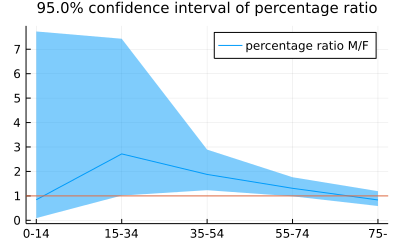

In [31]:
α = 0.05
RRCI2 = vcat((confint_rr_pearson(a2, m2-a2, c2, n2-c2; α)' for (m2, a2, n2, c2)
        in zip(df2."Male data size", df2."Male AED", df2."Female data size", df2."Female AED"))...)
RRCI2_L = RRCI2[:,1]
RRCI2_U = RRCI2[:,2]

plot(RRhat2; label="percentage ratio M/F", ribbon=(RRhat2-RRCI2_L, RRCI2_U-RRhat2))
hline!([1]; label="")
plot!(; xtick=xtick2, ytick=0:20)
title!("$(100(1-α))% confidence interval of percentage ratio")

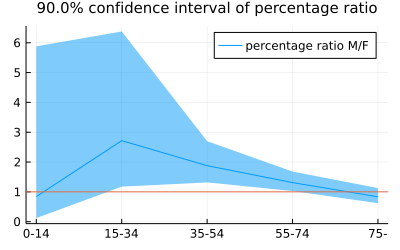

In [32]:
α = 0.10
RRCI2 = vcat((confint_rr_pearson(a2, m2-a2, c2, n2-c2; α)' for (m2, a2, n2, c2)
        in zip(df2."Male data size", df2."Male AED", df2."Female data size", df2."Female AED"))...)
RRCI2_L = RRCI2[:,1]
RRCI2_U = RRCI2[:,2]

plot(RRhat2; label="percentage ratio M/F", ribbon=(RRhat2-RRCI2_L, RRCI2_U-RRhat2))
hline!([1]; label="")
plot!(; xtick=xtick2, ytick=0:20)
title!("$(100(1-α))% confidence interval of percentage ratio")